<a href="https://colab.research.google.com/github/fariha-sadeque/coding/blob/main/(3_layer)pneumonaVsnormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow matplotlib numpy pillow

 Import Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

Set Up Data Paths

In [ ]:
# Update this path to your actual data location in Google Drive
base_dir = '/content/drive/MyDrive/data/dataXrayss'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Validation directory:", val_dir)

# Check if directories exist
print("Train exists:", os.path.exists(train_dir))
print("Test exists:", os.path.exists(test_dir))
print("Validation exists:", os.path.exists(val_dir))

Train directory: /content/drive/MyDrive/data/dataXrayss/train
Test directory: /content/drive/MyDrive/data/dataXrayss/test
Validation directory: /content/drive/MyDrive/data/dataXrayss/val
Train exists: True
Test exists: True
Validation exists: True


Data Preprocessing and Augmentation

In [ ]:
# Image parameters
img_height = 64
img_width = 64
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # binary for 2 classes
    color_mode='grayscale'  # convert to grayscale for MLP
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

# Print class indices
print("Class indices:", train_generator.class_indices)

Found 5219 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


Build the 3-Layer MLP Model

Cell 1: Diagnose Imbalance

In [ ]:
# --- STEP 1: Check for Class Imbalance and Calculate Weights ---
print("Training Set:")
unique, counts = np.unique(train_generator.classes, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class '{list(train_generator.class_indices.keys())[cls]}' ({cls}): {count} images")
print(f"  Total: {train_generator.samples} images")
print(f"  Ratio: {max(counts)/min(counts):.2f}:1")
print()

from sklearn.utils import class_weight
import numpy as np

# Calculate class weights to balance the loss function
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("\n✅ Class Weights for training:", class_weights_dict)

Training Set:
  Class 'NORMAL' (0): 1341 images
  Class 'PNEUMONIA' (1): 3878 images
  Total: 5219 images
  Ratio: 2.89:1


✅ Class Weights for training: {0: np.float64(1.9459358687546606), 1: np.float64(0.6728984012377515)}


Cell 2: Build Improved Model

In [ ]:
# --- STEP 2: Define an Improved Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Revised model with less dropout
model = Sequential([
    Flatten(input_shape=(img_height, img_width, 1)),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Reduced from 0.5
    Dense(256, activation='relu'),
    Dropout(0.2),  # Reduced from 0.3
    Dense(128, activation='relu'),
    Dropout(0.1),  # Reduced from 0.2
    Dense(1, activation='sigmoid')
])

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced from 0.001
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,017 (8.63 MB)

 Trainable params: 2,262,017 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Cell 3: Train with Weights & Callbacks


In [ ]:
# --- Calculate steps per epoch for training ---
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 163
Validation steps: 0


In [ ]:
# --- STEP 3: Train with Class Weights and Early Stopping ---
from tensorflow.keras.callbacks import EarlyStopping

# Callback to stop training when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, # Keeps the best model found during training
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30, # Set a high number, EarlyStopping will control the actual duration
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weights_dict, # ⭐ CRUCIAL: Add the calculated weights
    callbacks=[early_stop], # ⭐ Add the early stopping callback
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 1605s 10s/step - accuracy: 0.5252 - loss: 0.7073 - precision_2: 0.7561 - recall_2: 0.5335 - val_accuracy: 0.7500 - val_loss: 0.6673 - val_precision_2: 0.6667 - val_recall_2: 1.0000
Epoch 2/30
  1/163 ━━━━━━━━━━━━━━━━━━━━ 8:44 3s/step - accuracy: 0.6875 - loss: 0.6438 - precision_2: 0.8824 - recall_2: 0.6522

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6875 - loss: 0.6438 - precision_2: 0.8824 - recall_2: 0.6522 - val_accuracy: 0.7500 - val_loss: 0.6655 - val_precision_2: 0.6667 - val_recall_2: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.5714 - loss: 0.6794 - precision_2: 0.7900 - recall_2: 0.5868 - val_accuracy: 0.5000 - val_loss: 0.7516 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 0.7445 - precision_2: 0.8000 - recall_2: 0.1818 - val_accuracy: 0.5000 - val_loss: 0.7447 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 427ms/step - accuracy: 0.5771 - loss: 0.6694 - precision_2: 0.8079 - recall_2: 0.5751 - val_accuracy: 0.5000 - val_loss: 0.7785 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 0.5986 - precision_2: 1.0000 -

Evaluate the Model

In [ ]:
# Evaluate on test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"Test F1-Score: {test_f1:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 156s 8s/step - accuracy: 0.4802 - loss: 0.7048 - precision_2: 0.3462 - recall_2: 0.5980
Test Accuracy: 0.6731
Test Precision: 0.6906
Test Recall: 0.8641
Test F1-Score: 0.7677


Confusion Matrix

Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step

Confusion Matrix:
[[ 83 151]
 [ 53 337]]


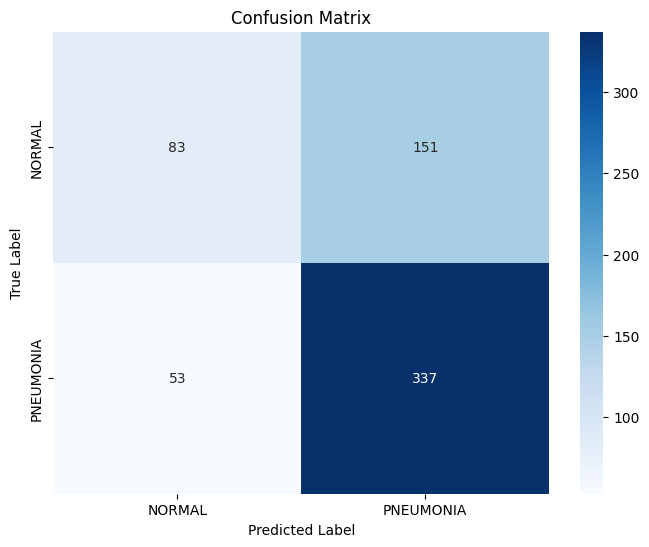


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.61      0.35      0.45       234
   PNEUMONIA       0.69      0.86      0.77       390

    accuracy                           0.67       624
   macro avg       0.65      0.61      0.61       624
weighted avg       0.66      0.67      0.65       624



In [ ]:
# --- Generate and Plot Confusion Matrix ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Get true labels and predictions from the test generator
print("Generating predictions...")
test_generator.reset() # Important: reset the generator
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten() # Convert probabilities to binary predictions

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = list(test_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Plot Training History

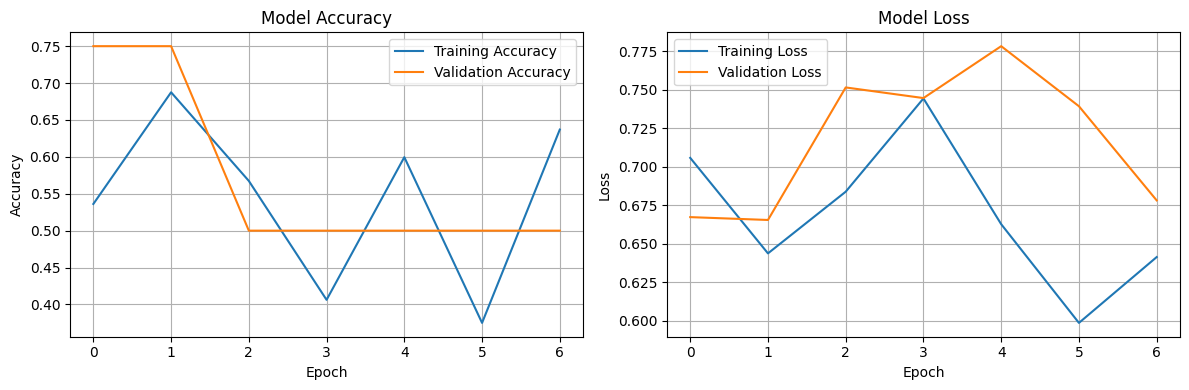

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Make Predictions and Show Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


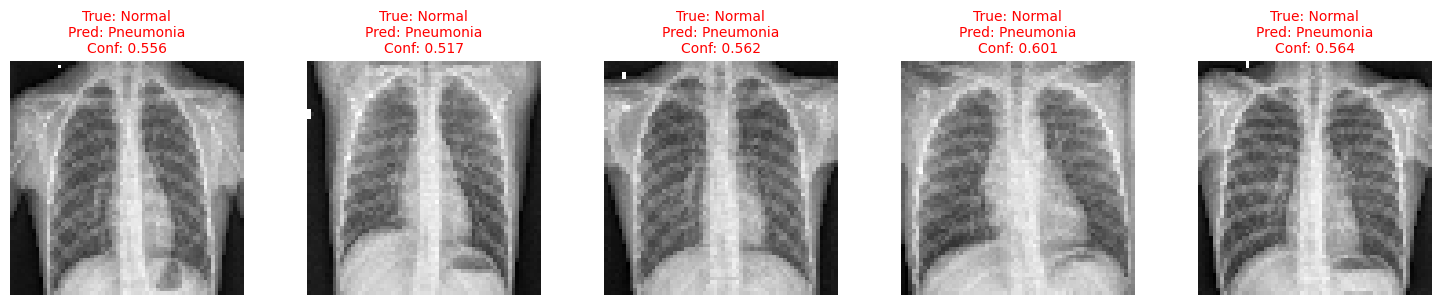

In [ ]:
# Get some test images and make predictions
def show_predictions(num_images=5):
    test_generator.reset()
    images, true_labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Display results
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]

    class_names = ['Normal', 'Pneumonia']

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        true_class = class_names[int(true_labels[i])]
        pred_class = class_names[predicted_labels[i]]
        confidence = predictions[i][0]

        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(5)

Save the Model

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/chest_xray_mlp_model.h5')
print("Model saved successfully!")

Model saved successfully!


Mount Drive and Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Load the trained model
model_path = '/content/drive/MyDrive/chest_xray_mlp_model.h5'
model = load_model(model_path)
print("✅ Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!


Define Image Preprocessing Function

In [ ]:
def preprocess_image(image_path, target_size=(64, 64)):
    """
    Preprocess image for prediction (same as training)
    """
    # Load and convert to grayscale
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size)

    # Convert to array and normalize
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

    return img_array, img

def predict_image(image_path):
    """
    Make prediction on a single image
    """
    # Preprocess image
    img_array, original_img = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(img_array)
    confidence = prediction[0][0]

    # Interpret results
    if confidence > 0.5:
        result = "PNEUMONIA"
        confidence_percent = confidence * 100
    else:
        result = "NORMAL"
        confidence_percent = (1 - confidence) * 100

    return result, confidence_percent, original_img

Simple Testing Interface

In [ ]:
# Simple testing loop
print("🩺 CHEST X-RAY PNEUMONIA DETECTOR")
print("="*40)

continue_testing = True

while continue_testing:
    print("\nSelect an option:")
    print("1. Test an image from Drive")
    print("2. Exit")

    choice = input("Enter your choice (1-2): ").strip()

    if choice == '1':
        # Get image path from user
        image_path = input("Enter the full path to the image (e.g., /content/drive/MyDrive/test.jpg): ").strip()

        # Check if file exists
        if not os.path.exists(image_path):
            print("❌ File not found! Please check the path.")
            continue

        try:
            # Make prediction
            result, confidence, original_img = predict_image(image_path)

            # Display results
            plt.figure(figsize=(8, 6))
            plt.imshow(original_img, cmap='gray')
            plt.title(f'Predicted: {result}\nConfidence: {confidence:.1f}%',
                     fontsize=14, pad=20, color='red' if result == "PNEUMONIA" else 'green')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            print(f"📊 Prediction: {result}")
            print(f"🎯 Confidence: {confidence:.1f}%")

            if result == "PNEUMONIA":
                print("🚨 Medical attention recommended!")
            else:
                print("✅ Chest X-ray appears normal")

        except Exception as e:
            print(f"❌ Error processing image: {e}")

    elif choice == '2':
        print("👋 Exiting... Stay healthy!")
        continue_testing = False

    else:
        print("❌ Invalid choice. Please try again.")

🩺 CHEST X-RAY PNEUMONIA DETECTOR

Select an option:
1. Test an image from Drive
2. Exit
Enter your choice (1-2): 2
👋 Exiting... Stay healthy!
